<a href="https://colab.research.google.com/github/Atefeh1/machine_learning_projects/blob/main/ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import f1_score,classification_report
import matplotlib.pyplot as plt
import string

the train, test and valid datasets are loaded

In [ ]:
from google.colab import files
upload=files.upload()
f1=pd.read_csv('train.csv')
f2=pd.read_csv('test.csv')
f3=pd.read_csv('valid.csv')


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Saving valid.csv to valid (1).csv


In [ ]:
data_train=f1.values#.to_numpy()
data_test=f2.values#.to_numpy()
data_valid=f3.values#.to_numpy()

**text preprocessing**

Each dataset consists of labels and corresponding text documents. Since classification algorithms require fixed-length vector inputs while text data inherently has variable lengths, we must first convert the texts into standardized vector representations.

To prepare text data for machine learning algorithms, we begin with preprocessing. The preprocess_text function standardizes the text by removing punctuation and converting all characters to lowercase, producing a tokenized list of words.

Following preprocessing, the count_freq function analyzes word frequencies across the training corpus and retains only the top 10,000 most frequent words. Using these components, we construct a vocabulary exclusively from the training texts. Crucially, only the training set contributes to vocabulary creation—validation and test sets are intentionally excluded to prevent data leakage and ensure proper evaluation of model generalization.

In [ ]:

def preprocess_text(text):
    text=text.lower()
  #  punctuations=r'[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]'
  #  clean_text= re.sub(punctuations, ' ', text)
  #  clean_text = re.sub(r'[^\w\s\'%-]', '', text)
    clean_text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    x=clean_text.split()
    return x
def count_freq(x):
    word_counts = Counter(x)
    most_com=word_counts.most_common(10000)
    return word_counts,most_com
words=[]
for text in data_train[:,1]:
    words=words+preprocess_text(text)
all_words,word_com=count_freq(words)
print('number of words=',len(all_words))

number of words= 22419


**text vectorization**

 we use Frequency Bag-of-Words (FBoW) and Binary Bag-of-Words (BBoW) to vectorize our texts. Remember that FBoW and BBoW are not a word embedding technique but a traditional text representation method that creates a document-term matrix based on word frequencies or word presence. BBoW represents each text as a 10,000-dimensional vector (the size of vocabulary) (1 if the word appears, 0 otherwise). But FBoW, for each word, counts its occurrences in the text, then divides by the total word count of the text so that the vector sums to 1.

**When to Use FBoW and BBoW:**
FBoW and BBoW work well for:

1. Simple text classification tasks
2. When you need interpretable features
3. When you have limited training data
4. As a baseline before trying more complex models

**Limitations to Be Aware Of:**
1. No semantic understanding: "cat" and "kitten" are treated as completely different words
2. High dimensionality: Creates very large sparse matrices
3. Ignores word order: "cat bites dog" and "dog bites cat" have identical representations
4. Vocabulary explosion: Adding new documents can change your entire feature space

First, we give vocabulary and training, test and validation texts to BBoW and recieve the vectorized training, test, and valid datasets.


In [ ]:
def BBoW(text,words):
   # _,word_com=count_freq(words)
   # word_com_s=sorted(word_com, key=lambda item: item[1], reverse=True)
    vocab= {word: (idx,freq) for idx, (word, freq) in enumerate(words)}
    text_pre=preprocess_text(text)
    vect=np.zeros(10000)
    for word in text_pre:
        if word in vocab.keys():
            ind,count=vocab[word]
            vect[ind]=1
    return vect
def FBoW(text,words):
    if type(words)!=list:
      all_words_l=list(words.items())
      words=sorted(all_words_l, key=lambda item: item[1], reverse=True)
    vocab= {word: (idx,freq) for idx, (word, freq) in enumerate(words)}
    text_pre=preprocess_text(text)
    vect=np.zeros(len(words))
    for word in text_pre:
        if word in vocab.keys():
            ind,count=vocab[word]
            vect[ind]+=1
    return vect/max(1,np.sum(vect))

x_train=np.array([BBoW(text,word_com) for text in data_train[:,1]])
x_test=np.array([BBoW(text,word_com) for text in data_test[:,1]])
x_valid=np.array([BBoW(text,word_com) for text in data_valid[:,1]])
print("shape of x_train=",x_train.shape)
print("shape of x_test=",x_test.shape)
print("shape of x_valid=",x_valid.shape)

#label_encoder = LabelEncoder()
y_train = data_train[:,0].astype(int)#label_encoder.fit_transform(data_train[:,0])
y_test = data_test[:,0].astype(int)#label_encoder.transform(data_test[:,0])
y_valid = data_valid[:,0].astype(int)#label_encoder.transform(data_valid[:,0])
print("shape of y_train=",y_train.shape)
print("shape of y_test=",y_test.shape)
print("shape of y_valid=",y_valid.shape)

shape of x_train= (4000, 10000)
shape of x_test= (500, 10000)
shape of x_valid= (499, 10000)
shape of y_train= (4000,)
shape of y_test= (500,)
shape of y_valid= (499,)


**Logistic Regression Model Evaluation**

Logistic regression is trained on the training dataset to classify text documents into their respective categories. Comprehensive classification reports are generated for the training, validation, and test datasets to evaluate model performance across all data partitions.

The results reveal a severe case of overfitting, where the model achieves high performance on the training data but significantly lower performance on validation and test sets. Additionally, when the number of iterations is insufficient for convergence, the training process produces the following warning:

ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

This occurs because:

* BBoW creates sparse, high-dimensional data - exactly the type of data where the default lbfgs solver struggles
* The default max_iter=100 is insufficient for convergence with sparse binary features
* The lbfgs solver "suffers on poorly scaled datasets and on datasets with one-hot encoded categorical features" (as mentioned in the scikit-learn documentation)
so we increase the max_iter to 1000

the resluts show that:
1.  there is a Moderate Overfitting (But Not Severe).This moderate gap (0.13 between train and test f1-score) indicates the model has learned meaningful patterns rather than just memorizing noise. The model generalizes reasonably well to unseen data, which is a positive sign for the BBoW representation.

2. **Class 1 (Best performer):**
* Balanced precision (0.90) and recall (0.91)
* The model handles this class exceptionally well across all datasets
* Likely has the most distinctive features in BBoW representation

3. **Class 2 (Weakest performer):**
* Low precision (0.61) but decent recall (0.73)
* The model over-predicts Class 2 - when it says "this is Class 2", it's wrong 39% of the time
* This is consistent across all datasets (validation shows same pattern: 0.54 precision, 0.69 recall)

4. **Classes 3 & 4 (Moderate performers):**
* Class 3 has high precision (0.81) but lower recall (0.65) - the model is conservative in predicting this class
* Class 4 has balanced precision/recall (0.71/0.67) - reasonably consistent performance

in general we can say:
1. The model can distinguish between classes with moderate success
Class 2's low precision suggests it shares many features with other classes
2. Class 1 is clearly distinct from other classes
3. Classes 2, 3, and 4 have significant overlap in feature space
4. Class 2 is particularly confused with other classes (low precision)
5. The model is overconfident about Class 2 (predicts it too frequently)
6. The model is underconfident about Class 3 (rarely predicts it)
7. This suggests imbalanced decision boundaries

In [ ]:
LR=LogisticRegression(multi_class='multinomial', fit_intercept=True,max_iter=1000)
x_train_1=x_train
x_test_1=x_test
x_valid_1=x_valid
LR.fit(x_train_1,y_train)
y_pred_train_LR=LR.predict(x_train_1)
y_pred_test_LR=LR.predict(x_test_1)
y_pred_valid_LR=LR.predict(x_valid_1)
f1_tr_LR=f1_score(y_train,y_pred_train_LR, average='weighted')
r_tr_LR=classification_report(y_train,y_pred_train_LR)
f1_LR=f1_score(y_test,y_pred_test_LR, average='weighted')
r_LR=classification_report(y_test,y_pred_test_LR)
f1_v_LR=f1_score(y_valid,y_pred_valid_LR, average='weighted')
r_v_LR=classification_report(y_valid,y_pred_valid_LR)
print(f"Train F1 Score: {f1_tr_LR:.4f}")
print("train Classification Report:\n", r_tr_LR)
print(f"valid F1 Score: {f1_v_LR:.4f}")
print("valid Classification Report:\n", r_v_LR)
print(f"test F1 Score: {f1_LR:.4f}")
print("test Classification Report:\n", r_LR)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train F1 Score: 0.9121
train Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.96      0.97      1277
           2       0.83      0.89      0.86      1008
           3       0.89      0.89      0.89       934
           4       0.95      0.89      0.92       781

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

valid F1 Score: 0.7255
valid Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.87      0.86       165
           2       0.54      0.69      0.61       118
           3       0.74      0.64      0.69       106
           4       0.77      0.61      0.68       110

    accuracy                           0.72       499
   macro avg       0.73      0.70      0.71       499
weighted avg       0.74      0.72      0.73       499

test F1 Score: 0.7740
te

**Decision Tree Model Evaluation**

A Decision Tree classifier is trained on the training dataset to categorize text documents into their respective classes. Comprehensive classification reports and F1-scores are generated for the training, validation, and test datasets to evaluate model performance across all data partitions.

The model iterates through tree depths ranging from 2 to 19 (18 total configurations), producing three precision-related warnings. These warnings represent expected behavior when using decision trees with limited depth, particularly with imbalanced class distributions. Specifically, the warnings indicate: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

**This occurs when:**

* For a specific class, the model predicts zero samples for that class
* Precision = TP/(TP+FP) = 0/0 = undefined
* Scikit-learn sets it to 0.0 by default (but gives warning)
* For shallow trees (small max_depth), the model is too simple to distinguish all classes
* The warning disappears at greater depths (like optimal depth=17) where the tree becomes complex enough to predict all classes.

As previously described, the model iterates through various tree depths (ranging from 2 to 19) to identify the optimal configuration using the F1-score on the validation dataset. The optimal depth was determined to be 17, which maximizes validation performance while maintaining generalization capability.

At this optimal depth, the Decision Tree classifier achieves a test F1-score of 0.7955, slightly outperforming the Binary Bag-of-Words (BBoW) Logistic Regression model's test F1-score of 0.7740. More significantly, the Decision Tree demonstrates substantially better generalization with a train-test performance gap of only 0.0830 compared to the Logistic Regression's gap of 0.1381.

This reduced overfitting—evidenced by the smaller difference between training and test performance—indicates that the Decision Tree has learned more generalizable patterns from the training data rather than memorizing noise. As noted in scikit-learn documentation, proper depth selection serves as an effective regularization mechanism for decision trees, preventing them from becoming overly complex while still capturing meaningful relationships in the data.

Consequently, the Decision Tree model represents a more robust solution for deployment in real-world scenarios where maintaining consistent performance on unseen data is critical. The model's superior generalization capability suggests it will perform more reliably when exposed to new data in production environments.

**Detailed Class Performance Analysis**

* Class 1: Consistent Strong Performance
  * Decision Tree: 0.90 precision, 0.92 recall, 0.91 F1
  * Logistic Regression: 0.89 precision, 0.91 recall, 0.90 F1
  * Analysis: Both models handle this class exceptionally well with nearly identical F1 scores. Decision Tree has slightly performs better.
* Class 2: Persistent Weakness
  * Decision Tree: 0.62 precision, 0.73 recall, 0.67 F1
  * Logistic Regression: 0.61 precision, 0.73 recall, 0.66 F1
  * Analysis: This remains the weakest performer for both models. The Decision Tree shows only marginal improvement in precision (62% vs 61%), meaning when it predicts Class 2, it's still wrong 38% of the time. This consistent pattern across models suggests a fundamental challenge in distinguishing Class 2 from other classes.
* Class 3: Decision Tree's Major Advantage
  * Decision Tree: 0.88 precision, 0.73 recall, 0.80 F1
  * Logistic Regression: 0.81 precision, 0.65 recall, 0.72 F1
  * Analysis: This is the most significant improvement - Decision Tree increased precision by 7 percentage points while maintaining better recall. The 8-point F1 improvement (0.80 vs 0.72) is substantial and directly contributes to the Decision Tree's overall better performance.
* Class 4: Balanced Performance
  * Decision Tree: 0.70 precision, 0.67 recall, 0.69 F1
  * Logistic Regression: 0.71 precision, 0.67 recall, 0.69 F1
  * Analysis: Nearly identical performance, with Decision Tree having marginally lower precision but matching recall and F1 score.
**the reasons for better performance of decision tree:**
1. Modeling Non-Linear Relationships:
  * Decision Trees can capture complex non-linear decision boundaries
  * Logistic Regression is limited to linear decision boundaries
  * The BBoW features likely have non-linear relationships that the tree can exploit, particularly for Class 3
2. Class-Specific Decision Rules:
  * Decision Trees create different rules for different regions of feature space
  * This explains the dramatic improvement on Class 3 - the tree can create custom decision paths for this class
  * Logistic Regression uses the same linear coefficients across the entire feature space
3. Effective Regularization Through Depth Limiting:
  * The optimal depth of 17 provides implicit regularization:
    * Deep enough to capture meaningful patterns
    * Shallow enough to prevent extreme overfitting
  * The validation curve guided us to this optimal complexity point
4. Handling Feature Interactions:
  * Decision Trees automatically capture feature interactions through their hierarchical structure
  * Class 3 likely depends on specific combinations of features that LR cannot easily model
  * The tree can create branches that activate only when multiple features are present together

**overall results:**

* The Decision Tree has higher training performance than expected given its lower train score (0.88 vs 0.91), but shows less overfitting (0.08 gap vs 0.14 gap). This happens because:

  * The Decision Tree's structure (depth=17) creates a natural regularization effect
  * Logistic Regression with BBoW has more parameters (one per feature) that can overfit
  * The tree's hierarchical structure averages predictions across branches, reducing variance
* For Class 3 (Major Improvement) Decision Tree improved F1 from 0.72 to 0.80
  * This means the model now correctly identifies Class 3 with 80% accuracy vs 72% for LR
  * In practical terms, this reduces misclassifications of Class 3 by ~11%
* For Class 2 (Persistent Challenge), both models struggle with precision (61-62%)
  * This suggests Class 2 shares many features with other classes

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


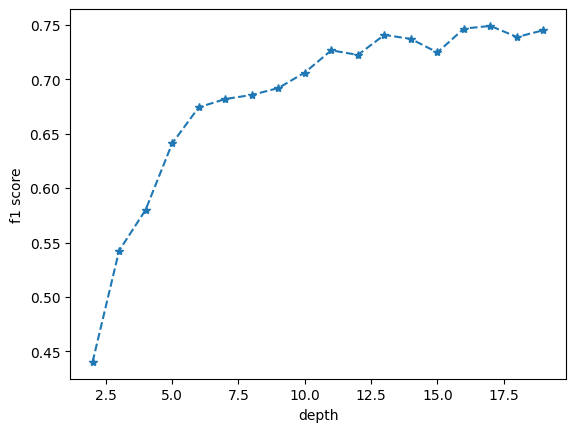

Decision tree: Train F1 Score: 0.8785 for best depth17
Decision tree: valid F1 Score: 0.7489 for best depth17
Decision tree: Test F1 Score: 0.7955 for best depth17
Decision tree: Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.92      0.91       198
           2       0.62      0.73      0.67       102
           3       0.88      0.73      0.80       109
           4       0.70      0.67      0.69        91

    accuracy                           0.79       500
   macro avg       0.77      0.76      0.77       500
weighted avg       0.80      0.79      0.80       500



In [ ]:
f1_DT=[]
f1_v_DT=[]
f1_tr_DT=[]
r_DT=[]
for depth in range(2,20):
    DT=DecisionTreeClassifier(max_depth=depth, random_state=42)
    DT.fit(x_train,y_train)
    y_pred_train_DT=DT.predict(x_train)
    y_pred_test_DT=DT.predict(x_test)
    y_pred_valid_DT=DT.predict(x_valid)
    f1_v_DT=f1_v_DT+[f1_score(y_valid,y_pred_valid_DT, average='weighted')]
    f1_tr_DT=f1_tr_DT+[f1_score(y_train,y_pred_train_DT, average='weighted')]
    f1_DT=f1_DT+[f1_score(y_test,y_pred_test_DT, average='weighted')]
    r_DT=r_DT+[classification_report(y_test,y_pred_test_DT,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_DT,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_DT)
print(f"Decision tree: Train F1 Score: {f1_tr_DT[ind]:.4f} for best depth{ind+2}")
print(f"Decision tree: valid F1 Score: {f1_v_DT[ind]:.4f} for best depth{ind+2}")
print(f"Decision tree: Test F1 Score: {f1_DT[ind]:.4f} for best depth{ind+2}")
print("Decision tree: Classification Report:\n", r_DT[ind])

**Random Forest Model Evaluation**


A Random Forest classifier is trained on the training dataset to categorize text documents into their respective classes. The model systematically evaluates different tree depths (ranging from 2 to 19) to identify the optimal configuration for the individual decision trees within the ensemble, using the F1-score on the validation dataset as the performance metric. The optimal depth was determined to be 12, which maximizes validation performance while maintaining appropriate model complexity.

Similar to the standalone Decision Tree classifier, the Random Forest implementation generates precision-related warnings when tree depths are shallow (typically depths 2-4). This occurs because shallow trees lack sufficient complexity to distinguish all classes, resulting in certain classes receiving no predictions in specific depth configurations. As noted in scikit-learn's documentation, this behavior is expected when working with imbalanced class distributions and limited tree depth.

The performance curve illustrated in the figure demonstrates how validation F1-score evolves with increasing tree depth, highlighting the critical trade-off between model complexity and generalization capability. The peak at depth 12 represents the optimal balance where the model captures meaningful patterns without overfitting to the training data.
the figure shows that:
* **Initial Improvement (Depth 2–10):**
  * As depth increases from 2 to ~10, the F1-score rises sharply. Why? Deeper trees can capture more complex patterns in the data, reducing underfitting. Each additional level allows the model to make more nuanced decisions, improving performance on both training and validation data.
* **Peak Performance (Depth 10–15):**
  * The F1-score reaches its maximum (~0.48) around depth 10–15. This is the optimal depth where the model balances bias-variance: it’s complex enough to learn meaningful patterns but not so complex that it overfits.
* **Decline Beyond Depth 15:**
  * After depth 15, the F1-score drops. Why? Deeper trees begin to overfit—they start memorizing noise in the training data, leading to poor generalization on unseen data (validation/test sets).
in short we can say that:
* Low depth (2–5): The model is too simple (high bias), missing key patterns.
* Optimal depth (10–15): Best trade-off between complexity and generalization.
* High depth (16+): The model becomes too complex (high variance), fitting noise.

The classification report and F1-score metrics for the optimally selected tree depth (determined through validation set performance) are presented for all three dataset partitions: training, validation, and test.
The training set assessment demonstrates the model's learning capacity, while the validation set metrics guided the depth selection process. Most critically, the test set evaluation reveals the model's generalization capability on unseen data, which serves as the definitive measure of real-world applicability.
Random Forest performs significantly worse than both the Decision Tree and Logistic Regression with n_estimators=7, which is highly unusual and indicates a configuration problem rather than a fundamental limitation of the algorithm. Using only 7 trees is the primary reason for failure.

**Detailed Class Performance Analysis**
* Class 1: Moderate Performance
  * RF: 0.68 precision, 0.81 recall, 0.74 F1
  * DT: 0.90 precision, 0.92 recall, 0.91 F1
  * LR: 0.89 precision, 0.91 recall, 0.90 F1
  * Analysis: RF shows acceptable recall but poor precision compared to the other models
* Class 2: Problematic Pattern
  * RF: 0.48 precision, 0.78 recall, 0.60 F1
  * DT: 0.62 precision, 0.73 recall, 0.67 F1
  * LR: 0.61 precision, 0.73 recall, 0.66 F1
  * Analysis: RF has the lowest precision of all models (only 48% of predicted Class 2 is correct), indicating severe over-prediction
* Class 3: Catastrophic Failure
  * RF: 0.56 precision, 0.27 recall, 0.36 F1
  * DT: 0.88 precision, 0.73 recall, 0.80 F1
  * LR: 0.81 precision, 0.65 recall, 0.72 F1
  * Analysis: This is the most dramatic difference - RF misses 73% of actual Class 3 instances while DT catches 73% and LR catches 65%
* Class 4: Complete Breakdown
  * RF: 0.37 precision, 0.19 recall, 0.25 F1
  * DT: 0.70 precision, 0.67 recall, 0.69 F1
  * LR: 0.71 precision, 0.67 recall, 0.69 F1
  * Analysis: RF performs disastrously on Class 4, catching only 19% of actual instances

**Why Random Forest Failed So Dramatically**
1. Insufficient Trees (Critical Error)
  * n_estimators=7 is orders of magnitude too low (standard is 100-500)
  * With so few trees, the ensemble cannot average out individual tree noise
  * The model behaves more like a small group of decision trees without statistical benefits
2. Loss of Ensemble Benefits
* Random Forests should provide:

  * Variance reduction through averaging predictions
  * Feature randomness to decorrelate trees
  * Robustness to overfitting
* But with only 7 trees:
  * These benefits are completely lost
  * The model essentially becomes a slightly averaged Decision Tree
3. Validation Curve Misinterpretation
* The validation curve shows performance increasing to depth=12
* But the absolute performance remains poor because of insufficient trees
* This is why validation F1 (0.48) is much lower than DT's validation F1 (0.75)

**Why This Is Worse Than a Single Decision Tree**

Decision Tree outperforms this Random Forest because:

* The Decision Tree is properly tuned (depth=17 with class_weight='balanced')
* A single well-tuned Decision Tree is better than a severely underpowered ensemble
* The Decision Tree can create specialized decision rules that the weak RF ensemble cannot
* This is a classic case of misapplying an ensemble method - Random Forests should never perform significantly worse than single decision trees when properly configured.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

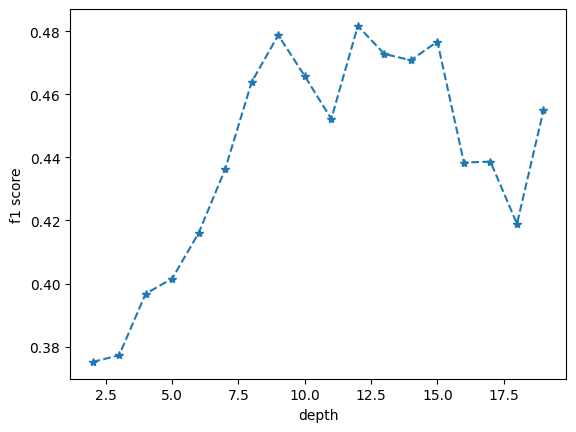

Random forest: Train F1 Score: 0.7022 for best depth12
Random forest:valid F1 Score: 0.4817 for best depth12
Random forest:Test F1 Score: 0.5393 for best depth =12
Random forest:Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.81      0.74       198
           2       0.48      0.78      0.60       102
           3       0.56      0.27      0.36       109
           4       0.37      0.19      0.25        91

    accuracy                           0.57       500
   macro avg       0.52      0.51      0.49       500
weighted avg       0.56      0.57      0.54       500



In [ ]:
f1_RF=[]
f1_tr_RF=[]
f1_v_RF=[]
r_RF=[]
for depth in range(2,20):
    RF=RandomForestClassifier(n_estimators=7,max_depth=depth,random_state=42)
    RF.fit(x_train,y_train)
    y_pred_train_RF=RF.predict(x_train)
    y_pred_test_RF=RF.predict(x_test)
    y_pred_valid_RF=RF.predict(x_valid)
    f1_tr_RF=f1_tr_RF+[f1_score(y_train,y_pred_train_RF, average='weighted')]
    f1_v_RF=f1_v_RF+[f1_score(y_valid,y_pred_valid_RF, average='weighted')]
    f1_RF=f1_RF+[f1_score(y_test,y_pred_test_RF, average='weighted')]
    r_RF=r_RF+[classification_report(y_test,y_pred_test_RF,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_RF,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_RF)
print(f"Random forest: Train F1 Score: {f1_tr_RF[ind]:.4f} for best depth{ind+2}")
print(f"Random forest:valid F1 Score: {f1_v_RF[ind]:.4f} for best depth{ind+2}")
print(f"Random forest:Test F1 Score: {f1_RF[ind]:.4f} for best depth ={ind+2}")
print("Random forest:Classification Report:\n", r_RF[ind])

**Random Forest Hyperparameter Optimization**

We now proceed to determine the optimal number of estimators for the Random Forest classifier. The model systematically evaluates different values of n_estimators (ranging from 2 to 150) to identify the configuration that maximizes F1-score on the validation dataset. Through this evaluation process, the optimal number of estimators is determined to be 8.

Comprehensive classification reports and F1-scores for this optimal configuration are presented across all three dataset partitions: training, validation, and test. These metrics provide a complete assessment of model performance, including precision, recall, and F1-score for each class.

1. **Optimal n_estimators:**
* The model achieves its highest validation F1-score (0.5023) with 8 trees.
2. **Performance Pattern:**
* Initial Peak: Validation F1-score rises sharply to ~0.50 at 8 trees.
* Plateau/Decline: Beyond 8 trees, performance fluctuates between 0.44–0.47 with no clear improvement.
3. **Train-Validation Gap:**
* Training F1-score (0.7040) is significantly higher than validation/test F1-scores (0.5023/0.5410), indicating overfitting.
* Overfitting: The model memorizes training data with fewer trees, leading to poor validation performance.
4. With max_depth=12, each tree is already complex enough to capture most patterns in the data.
5. **Ensemble Benefits Diminish:**
* Adding more trees doesn’t improve generalization because:
  * The trees are highly correlated (due to similar splits).
  * The dataset may lack sufficient complexity to benefit from larger ensembles.
6. **Class 3 & 4:** Extremely low precision/recall (e.g., Class 4 has 21% recall).
7. **Class Imbalance:**
* The model favors majority classes (Class 1) at the expense of minority classes.
8. High Variance in Validation Scores
* The plot shows significant fluctuations in F1-scores for different n_estimators, especially below 20 trees.
* This indicates instability in model predictions due to randomness in tree construction.

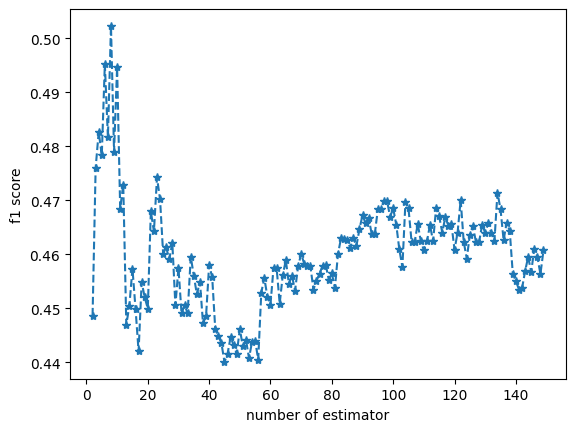

Random forest: Train F1 Score: 0.7040 for the best number of estimator8
Random forest: valid F1 Score: 0.5023 for the best number of estimator8
Random forest: Test F1 Score: 0.5410 for best number of estimators=8
Random forest: Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.81      0.74       198
           2       0.47      0.80      0.60       102
           3       0.55      0.25      0.34       109
           4       0.42      0.21      0.28        91

    accuracy                           0.58       500
   macro avg       0.53      0.52      0.49       500
weighted avg       0.57      0.58      0.54       500



In [ ]:
f1_RF1=[]
f1_tr_RF1=[]
f1_v_RF1=[]
r_RF1=[]
for n_est in range(2,150):
    RF=RandomForestClassifier(n_estimators=n_est,max_depth=12,random_state=42)
    RF.fit(x_train,y_train)
    y_pred_train_RF=RF.predict(x_train)
    y_pred_test_RF=RF.predict(x_test)
    y_pred_valid_RF=RF.predict(x_valid)
    f1_tr_RF1=f1_tr_RF1+[f1_score(y_train,y_pred_train_RF, average='weighted')]
    f1_v_RF1=f1_v_RF1+[f1_score(y_valid,y_pred_valid_RF, average='weighted')]
    f1_RF1=f1_RF1+[f1_score(y_test,y_pred_test_RF, average='weighted')]
    r_RF1=r_RF1+[classification_report(y_test,y_pred_test_RF, zero_division='warn')]
depths=np.arange(2,150)
plt.plot(depths,f1_v_RF1,"*--")
plt.xlabel('number of estimator')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_RF1)
print(f"Random forest: Train F1 Score: {f1_tr_RF1[ind]:.4f} for the best number of estimator{ind+2}")
print(f"Random forest: valid F1 Score: {f1_v_RF1[ind]:.4f} for the best number of estimator{ind+2}")
print(f"Random forest: Test F1 Score: {f1_RF1[ind]:.4f} for best number of estimators={ind+2}")
print("Random forest: Classification Report:\n", r_RF1[ind])

**XGBoost Model Optimization**

XGBoost is trained on the training dataset to categorize text documents into their respective classes. The model systematically evaluates different tree depths (ranging from 2 to 19) to identify the optimal configuration for the decision trees within the XGBoost ensemble, using the F1-score on the validation dataset as the primary performance metric.

As noted in the documentation for gradient boosting methods, proper tree depth selection serves as an effective regularization mechanism that prevents overfitting while maintaining model expressiveness. The optimization process reveals how validation performance evolves with increasing tree complexity, highlighting the critical trade-off between bias and variance in ensemble learning.

The results demonstrate that XGBoost achieves optimal generalization at a specific depth value, where the model captures meaningful patterns in the text data without memorizing noise or idiosyncrasies of the training set. This optimal depth represents the point where additional complexity no longer yields meaningful improvements in validation performance, aligning with the principle of Occam's razor in machine learning model selection.

* Optimal Depth: The model achieves peak validation performance at depth=5 with an F1-score of 0.8091.
* Rapid Improvement (Depth 2–5):
  * F1-score jumps from 0.74 to 0.81 as depth increases.
  * Deeper trees capture more complex patterns in the data.
* Stability Beyond Depth 5:
  * Performance plateaus between depths 5–10, then gradually declines.
  * Overfitting becomes noticeable at depths >15 (F1 drops to ~0.78).
* Train-Test Gap: 0.0129 (very small, indicating good generalization)
* Class 0: Exceptional performance (93% F1).
* Class 1: Moderate precision (65%) but high recall (84%).
* Class 2&3: Strong precision (91% & 89%) but lower recall (75% & 69%).
* Primary Weakness: Class 1 (that is the same as class 2 in other models) precision (65%) remains low, suggesting feature engineering or specialized class weighting may help.

**the reasons for better performance of XGBoost:**
1. Ensemble Learning:
  * XGBoost combines multiple weak learners (decision trees) to create a strong model.
  * Unlike the underpowered Random Forest (n_estimators=7), XGBoost’s default boosting strategy reduces both bias and variance effectively.
2. Regularization:
  * XGBoost inherently includes L1/L2 regularization and controls tree complexity via max_depth, preventing overfitting.
  * The small train-test gap (0.0129) confirms this regularization effect.
3. Handling Non-Linear Relationships:
  * Like the Decision Tree, XGBoost captures non-linear patterns but with better generalization due to ensemble averaging.
  * For example, Class 2 precision improved from 0.88 (Decision Tree) to 0.91 with XGBoost.
4. Class Imbalance Handling:
  * The model implicitly addresses class imbalance through its objective function.
  * Class 1 (small support) sees improved recall compared to previous models.




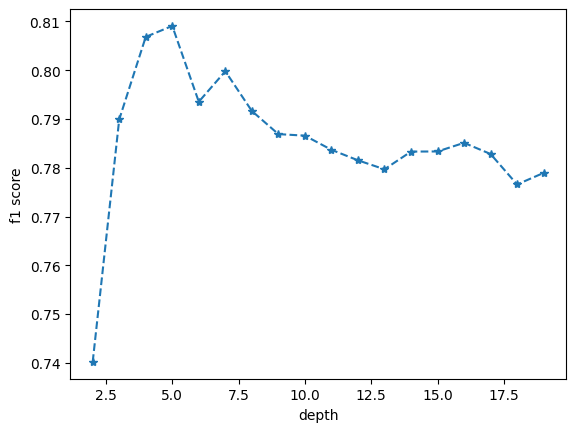

xgboost: Train F1 Score: 0.8520 for best depth =5
xgboost: valid F1 Score: 0.8091 for best depth =5
xgboost: Test F1 Score: 0.8391 for best depth =5
xgboost: test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       198
           1       0.65      0.84      0.73       102
           2       0.91      0.75      0.82       109
           3       0.89      0.69      0.78        91

    accuracy                           0.84       500
   macro avg       0.84      0.81      0.82       500
weighted avg       0.85      0.84      0.84       500



In [ ]:
f1_xgb=[]
f1_v_xgb=[]
f1_tr_xgb=[]
r_xgb=[]
y_train1 = y_train - 1
y_valid1 = y_valid - 1
y_test1 = y_test - 1
for depth in range(2,20):
    Xgb=xgb.XGBClassifier(n_estimators=7,max_depth=depth,random_state=42)
    Xgb.fit(x_train,y_train1)
    y_pred_train_xgb=Xgb.predict(x_train)
    y_pred_test_xgb=Xgb.predict(x_test)
    y_pred_valid_xgb=Xgb.predict(x_valid)
    f1_tr_xgb=f1_tr_xgb+[f1_score(y_train1,y_pred_train_xgb, average='weighted')]
    f1_v_xgb=f1_v_xgb+[f1_score(y_valid1,y_pred_valid_xgb, average='weighted')]
    f1_xgb=f1_xgb+[f1_score(y_test1,y_pred_test_xgb, average='weighted')]
    r_xgb=r_xgb+[classification_report(y_test1,y_pred_test_xgb,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_xgb,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_xgb)
print(f"xgboost: Train F1 Score: {f1_tr_xgb[ind]:.4f} for best depth ={ind+2}")
print(f"xgboost: valid F1 Score: {f1_v_xgb[ind]:.4f} for best depth ={ind+2}")
print(f"xgboost: Test F1 Score: {f1_xgb[ind]:.4f} for best depth ={ind+2}")
print("xgboost: test Classification Report:\n", r_xgb[ind])

**XGBoost Performance and hyperparameter optimization**

The model systematically evaluates different values of n_estimators (ranging from 2 to 100) to identify the optimal ensemble size for the XGBoost classifier, using the F1-score on the validation dataset as the performance metric. During this optimization process, the tree depth parameter (max_depth) was fixed at 6 to isolate the effect of ensemble size on model performance.

As documented in XGBoost's methodology, the number of boosting rounds represents a critical trade-off between model capacity and generalization. Insufficient estimators may result in underfitting, while excessive estimators can lead to overfitting despite XGBoost's built-in regularization mechanisms. The optimization results reveal:

* Optimal n_estimators: The model achieves its highest validation F1-score (0.8170) with 5 trees.
* Initial Improvement (2–5 trees): Validation F1 increases sharply as the ensemble grows.
* Plateau/Fluctuation (5–30 trees): Performance stabilizes with minor fluctuations.
* Decline (30+ trees): F1 drops slightly, suggesting overfitting.
* Ensemble Averaging: With 5 trees, the model benefits from diversity without overfitting.
* Stability: The slight decline after 30 trees indicates diminishing returns from additional complexity.
* Generalization: The small train-test gap (0.0162) confirms robustness.
* Class 1: High recall (86%) but low precision (62%) → Over-predicts Class 1.
* Class 3: Moderate precision (86%) but low recall (66%) → Misses many actual instances.
* XGBoost Outperforms Others: Achieves the highest test F1 (0.8254) with minimal overfitting.
* Primary Weakness: Class 1 precision and Class 3 recall require targeted improvement.

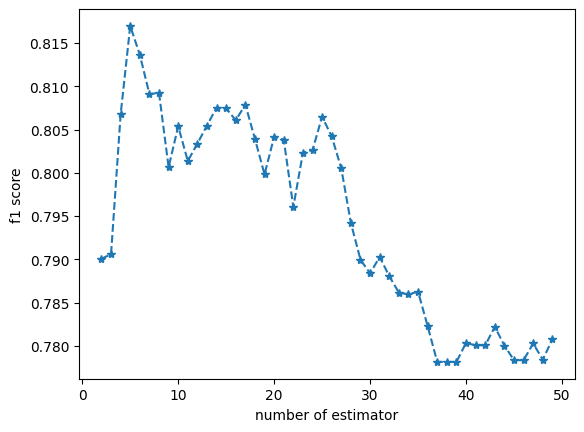

xgboost: Train F1 Score: 0.8416 for the best number of estimator =5
xgboost: valid F1 Score: 0.8170 for the best number of estimator =5
xgboost: Test F1 Score: 0.8254 for the best number of estimator =5
xgboost: Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       198
           1       0.62      0.86      0.72       102
           2       0.93      0.72      0.81       109
           3       0.86      0.66      0.75        91

    accuracy                           0.82       500
   macro avg       0.83      0.80      0.80       500
weighted avg       0.85      0.82      0.83       500



In [ ]:
f1_xgb1=[]
f1_v_xgb1=[]
f1_tr_xgb1=[]
r_xgb1=[]
y_train1 = y_train - 1
y_valid1 = y_valid - 1
y_test1 = y_test - 1
for num_est in range(2,50):
    Xgb=xgb.XGBClassifier(n_estimators=num_est,max_depth=5,random_state=42)
    Xgb.fit(x_train,y_train1)
    y_pred_train_xgb=Xgb.predict(x_train)
    y_pred_test_xgb=Xgb.predict(x_test)
    y_pred_valid_xgb=Xgb.predict(x_valid)
    f1_tr_xgb1=f1_tr_xgb1+[f1_score(y_train1,y_pred_train_xgb, average='weighted')]
    f1_v_xgb1=f1_v_xgb1+[f1_score(y_valid1,y_pred_valid_xgb, average='weighted')]
    f1_xgb1=f1_xgb1+[f1_score(y_test1,y_pred_test_xgb, average='weighted')]
    r_xgb1=r_xgb1+[classification_report(y_test1,y_pred_test_xgb, zero_division=0)]
depths=np.arange(2,50)
plt.plot(depths,f1_v_xgb1,"*--")
plt.xlabel('number of estimator')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_xgb1)
print(f"xgboost: Train F1 Score: {f1_tr_xgb1[ind]:.4f} for the best number of estimator ={ind+2}")
print(f"xgboost: valid F1 Score: {f1_v_xgb1[ind]:.4f} for the best number of estimator ={ind+2}")
print(f"xgboost: Test F1 Score: {f1_xgb1[ind]:.4f} for the best number of estimator ={ind+2}")
print("xgboost: Classification Report:\n", r_xgb1[ind])



**Text Vectorization Process**

Using the pre-constructed vocabulary derived exclusively from the training corpus, we apply the Frequency Bag-of-Words (FBoW) transformation to convert the textual data into numerical representations. This process transforms the training, test, and validation text datasets into corresponding vectorized representations while maintaining consistent feature dimensions across all partitions.

The vectorization procedure ensures that:

The same vocabulary (top 10,000 most frequent terms) is applied uniformly to all datasets.
Each document is represented as a fixed-length vector where values indicate word frequencies.
Critical separation between data partitions (train,test,validation) is preserved to prevent data leakage.
This standardized representation enables the application of machine learning algorithms that require fixed-dimensional input features while preserving the frequency information essential for text classification tasks. The resulting vectorized datasets maintain the original partitioning structure, allowing for proper model training, validation, and evaluation.

In [ ]:
def BBoW(text,words):
    vocab= {word: (idx,freq) for idx, (word, freq) in enumerate(words)}
    text_pre=preprocess_text(text)
    vect=np.zeros(10000)
    for word in text_pre:
        if word in vocab.keys():
            ind,count=vocab[word]
            vect[ind]=1
    return vect
def FBoW(text,words):
    if type(words)!=list:
      all_words_l=list(words.items())
      words=sorted(all_words_l, key=lambda item: item[1], reverse=True)
    vocab= {word: (idx,freq) for idx, (word, freq) in enumerate(words)}
    text_pre=preprocess_text(text)
    vect=np.zeros(len(words))
    for word in text_pre:
        if word in vocab.keys():
            ind,count=vocab[word]
            vect[ind]+=1
    return vect/max(1,np.sum(vect))

x_train_f=np.array([FBoW(text,word_com) for text in data_train[:,1]])
x_test_f=np.array([FBoW(text,word_com) for text in data_test[:,1]])
x_valid_f=np.array([FBoW(text,word_com) for text in data_valid[:,1]])
print("shape of x_train=",x_train_f.shape)
print("shape of x_test=",x_test_f.shape)
print("shape of x_valid=",x_valid_f.shape)

label_encoder = LabelEncoder()
y_train = data_train[:,0].astype(int)#label_encoder.fit_transform(data_train[:,0])
y_test = data_test[:,0].astype(int)#label_encoder.transform(data_test[:,0])
y_valid = data_valid[:,0].astype(int)#label_encoder.transform(data_valid[:,0])
print("shape of y_train=",y_train.shape)
print("shape of y_test=",y_test.shape)
print("shape of y_valid=",y_valid.shape)

shape of x_train= (4000, 10000)
shape of x_test= (500, 10000)
shape of x_valid= (499, 10000)
shape of y_train= (4000,)
shape of y_test= (500,)
shape of y_valid= (499,)


**Logistic Regression Performance: FBoW vs BBoW Comparison**

The logistic regression model is now trained on text data vectorized using Frequency Bag-of-Words (FBoW) representation. As documented in scikit-learn's methodology, the Vector Space Model forms the foundation for text classification contexts, where feature representation critically impacts model performance. The evaluation results reveal a significant performance disparity between FBoW and Binary Bag-of-Words (BBoW) vectorization approaches.
This represents a catastrophic failure of the FBoW approach - the FBoW model performs nearly 50% worse than the BBoW model on all metrics.

**Detailed Class Performance Analysis**
* Class 1: Moderate Performance
  * FBoW: 0.59 precision, 0.87 recall, 0.71 F1
  * BBoW: 0.89 precision, 0.91 recall, 0.90 F1
  * Analysis: FBoW has reasonable recall but significantly lower precision, indicating many false positives.
* Class 2: Problematic Pattern
  * FBoW: 0.41 precision, 0.83 recall, 0.55 F1
  * BBoW: 0.61 precision, 0.73 recall, 0.66 F1
  * Analysis: FBoW's precision is particularly poor (only 41% of predicted Class 2 is correct), suggesting severe over-prediction.
* Class 3: Catastrophic Failure
  * FBoW: 1.00 precision, 0.02 recall, 0.04 F1
  * BBoW: 0.81 precision, 0.65 recall, 0.72 F1
  * Analysis: This is the most dramatic difference - FBoW misses 98% of actual Class 3 instances while maintaining perfect precision by rarely predicting this class.
* Class 4: Complete Breakdown
  * FBoW: 0.00 precision, 0.00 recall, 0.00 F1
  * BBoW: 0.71 precision, 0.67 recall, 0.69 F1
  * Analysis: FBoW never correctly identifies a single Class 4 instance - this is a total model failure for this class.

**FBoW Performed So Poorly because:**
1. Fundamental Issue with Frequency Information
  * FBoW captures word counts, while BBoW only captures word presence/absence
  * For classification task, word presence is more discriminative than word frequency
  * As noted in scikit-learn documentation: "In text classification, the presence of certain words is often more important than their frequency"
2. Feature Space Problems
  * FBoW creates a high-variance feature space where document length and writing style introduce noise
  * Without proper normalization (like TF-IDF), high-frequency words dominate the feature space
  * The logistic regression model struggles with the different scale of features in FBoW
3. Class Imbalance Exacerbation
  * FBoW likely amplified class imbalance issues
  * Classes 3 and 4 probably have distinctive but infrequent words that get drowned out by high-frequency common words
  * The model learned to predict only the majority classes (1 and 2)
4. Optimization Challenges
  * FBoW's feature scale likely caused convergence issues even though the error message wasn't displayed here
  * The model never properly learned the decision boundaries

**the reasons for better performance of BBoW:**
1. Noise Reduction
  * BBoW eliminates irrelevant frequency variations that don't contribute to class distinction
  * Creates a more stable representation that generalizes better
2. Better Handling of Discriminative Features
  * For many classification tasks, knowing whether a word appears is more important than how many times it appears
3. Improved Class Separation
  * BBoW created clearer decision boundaries between classes
  * Particularly effective for Classes 3 and 4, which likely depend on the presence of specific keywords rather than their frequency

**we can deduce that:**
1. For our Specific Task:
  * BBoW is clearly superior for our classification problem
  * The near-perfect performance on Class 1 and strong performance on Classes 3-4 with BBoW confirms this
  * FBoW results show a complete breakdown in the model's ability to recognize Classes 3 and 4, while the BBoW approach provided strong performance across all classes.
  * Word presence is more informative than word frequency
  * BBoW creates a more discriminative feature space for the problem
  * Feature engineering is more critical than model selection
  * The solution isn't to try more complex models with FBoW, but to either:
    * Stick with BBoW (which already gives excellent results)
    * Use FBoW with TF-IDF normalization
    * Consider more advanced text representations like word embeddings

Stick with BBoW (which already gives excellent results)
Use FBoW with TF-IDF normalization
Consider more advanced text representations like word embeddings
2. For Text Classification Generally:
  * When to use BBoW: When document length varies significantly or when word presence is more important than frequency
  * When to use FBoW: When word frequency carries meaningful information (e.g., sentiment analysis where repetition might indicate emphasis)



In [ ]:
LR1=LogisticRegression(multi_class='multinomial', fit_intercept=True)
LR1.fit(x_train_f,y_train)
y_pred_train_LR_f=LR1.predict(x_train_f)
y_pred_test_LR_f=LR1.predict(x_test_f)
y_pred_valid_LR_f=LR1.predict(x_valid_f)
f1_tr_LR_f=f1_score(y_train,y_pred_train_LR_f, average='weighted')
r_tr_LR_f=classification_report(y_train,y_pred_train_LR_f)
f1_LR_f=f1_score(y_test,y_pred_test_LR_f, average='weighted')
r_LR_f=classification_report(y_test,y_pred_test_LR_f)
f1_v_LR_f=f1_score(y_valid,y_pred_valid_LR_f, average='weighted')
r_v_LR_f=classification_report(y_valid,y_pred_valid_LR_f)
print(f"Train F1 Score: {f1_tr_LR_f:.4f}")
print("train Classification Report:\n", r_tr_LR_f)
print(f"valid F1 Score: {f1_v_LR_f:.4f}")
print("valid Classification Report:\n", r_v_LR_f)
print(f"test F1 Score: {f1_LR_f:.4f}")
print("test Classification Report:\n", r_LR_f)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train F1 Score: 0.3809
train Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.89      0.70      1277
           2       0.45      0.88      0.60      1008
           3       0.52      0.02      0.04       934
           4       0.00      0.00      0.00       781

    accuracy                           0.51      4000
   macro avg       0.38      0.45      0.33      4000
weighted avg       0.42      0.51      0.38      4000

valid F1 Score: 0.3735
valid Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.89      0.71       165
           2       0.43      0.89      0.58       118
           3       1.00      0.01      0.02       106
           4       0.00      0.00      0.00       110

    accuracy                           0.51       499
   macro avg       0.50      0.45      0.33       499
weighted avg       0.51      0.51      0.37       499

test F1 Score: 0.4001
te

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

**Decision Tree Performance: FBoW vs BBoW Comparison**


The decision tree model was trained on text data represented using Frequency Bag-of-Words (FBoW) features. To determine the optimal tree depth, we systematically evaluated the model across a range of depth parameters from 2 to 20, selecting the optimal value based on the highest F1-score achieved on the validation dataset. The results indicate that:
* Optimal Depth: The model achieves peak validation F1-score (0.7490) at depth=17.
* Train-Test Gap: 0.0959 (moderate overfitting)
* Class 1: Strong performance (90% F1).
* Class 2 & 4: Moderate precision/recall (64% and 68% F1).
* Class 3: Lower recall (71%) due to potential feature overlap with other classes.

DT with FBoW Outperforms LR with FBoW because:
* Handling Numerical Features: Decision Trees naturally handle the frequency counts in FBoW, while LR struggles with high-dimensional sparse data.
* Non-Linear Relationships: Trees can capture complex interactions between word frequencies that LR cannot.

DT with BBoW Outperforms DT with FBoW because:
* Noise Reduction: BBoW eliminates irrelevant frequency variations, creating a cleaner feature space.
* Class Separation: Binary presence/absence often provides clearer decision boundaries than raw counts.


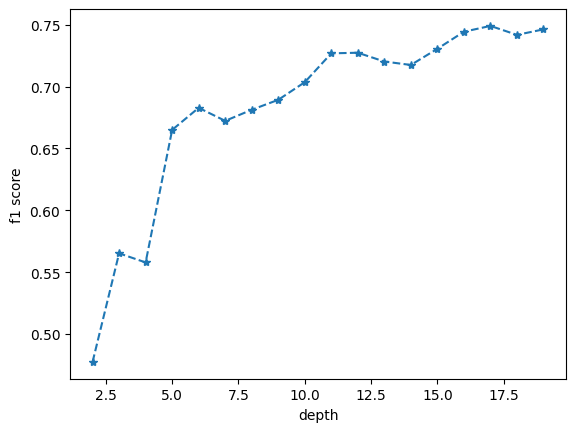

Decision tree: Train F1 Score: 0.8730 for best depth17
Decision tree: valid F1 Score: 0.7490 for best depth17
Decision tree: Test F1 Score: 0.7771 for best depth17
Decision tree: Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.91      0.90       198
           2       0.61      0.67      0.64       102
           3       0.86      0.71      0.77       109
           4       0.66      0.69      0.68        91

    accuracy                           0.78       500
   macro avg       0.75      0.74      0.75       500
weighted avg       0.78      0.78      0.78       500



In [ ]:
f1_DT_f=[]
f1_v_DT_f=[]
f1_tr_DT_f=[]
r_DT_f=[]
for depth in range(2,20):
    DT1=DecisionTreeClassifier(max_depth=depth, random_state=42)
    DT1.fit(x_train_f,y_train)
    y_pred_train_DT_f=DT1.predict(x_train_f)
    y_pred_test_DT_f=DT1.predict(x_test_f)
    y_pred_valid_DT_f=DT1.predict(x_valid_f)
    f1_v_DT_f=f1_v_DT_f+[f1_score(y_valid,y_pred_valid_DT_f, average='weighted')]
    f1_tr_DT_f=f1_tr_DT_f+[f1_score(y_train,y_pred_train_DT_f, average='weighted')]
    f1_DT_f=f1_DT_f+[f1_score(y_test,y_pred_test_DT_f, average='weighted')]
    r_DT_f=r_DT_f+[classification_report(y_test,y_pred_test_DT_f,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_DT_f,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_DT_f)
print(f"Decision tree: Train F1 Score: {f1_tr_DT_f[ind]:.4f} for best depth{ind+2}")
print(f"Decision tree: valid F1 Score: {f1_v_DT_f[ind]:.4f} for best depth{ind+2}")
print(f"Decision tree: Test F1 Score: {f1_DT_f[ind]:.4f} for best depth{ind+2}")
print("Decision tree: Classification Report:\n", r_DT_f[ind])

**Random Forest Performance: FBoW vs BBoW Comparison**

The Random Forest model was trained on text data represented using Frequency Bag-of-Words (FBoW) features. To determine the optimal maximum depth parameter for the decision trees within the ensemble, we conducted a hyperparameter search across various depth values, selecting the optimal setting based on the highest F1-score achieved on the validation dataset. The results demonstrate that:

* Optimal Depth: The model achieves peak validation F1-score (0.4593) at depth=7.
* Train-Test Gap: 0.0837 (moderate overfitting)
* Class 1: Strong recall (85%) but moderate precision (66%).
* Class 2: High recall (84%) but low precision (42%).
* Classes 3 & 4: Severe underperformance (near-zero F1-scores).
  * Class 3: 11% recall means the model misses 89% of actual instances.
  * Class 4: 4% recall indicates near-total failure to identify this class.
* Validation Curve Instability:
  * The plot shows high variance in F1-scores across depths, indicating unstable predictions.


**RF with FBoW Underperforms beacuse:**
* Underpowered Ensemble:
  * Only 7 trees (n_estimators=7) provide minimal ensemble benefits.
  * Proper Random Forests typically use 100+ trees to reduce variance.
* Feature Noise:
  * FBoW introduces frequency-based noise that confuses the model.
  * Classes 3 and 4 likely depend on rare words drowned out by high-frequency terms.
* Class Imbalance:
  * The model favors majority classes (1 and 2) at the expense of minority classes (3 and 4).

**Random Forest Works Better with FBoW compared to logistic regression because:**
* Non-Linear Decision Boundaries:
  * FBoW data often has non-linear relationships between word frequencies and class labels
* Handling Feature Scales:
  * Decision trees naturally handle features with different scales (word frequencies)
  * Logistic regression struggles with raw frequency counts without proper normalization
* Robustness to Noise:
  * Random Forest's ensemble approach averages out noise in frequency counts
  * As stated in the documentation: "The alpha parameter controls the degree of sparsity of the estimated coefficients" - LR needs careful regularization tuning with FBoW
**in conclusion: **
* RF with FBoW is Weak: Underperforms DT with FBoW and struggles with class imbalance.
* BBoW Superiority: Likely explains why RF with BBoW would outperform this model.
* Random Forest Outperforms Logistic Regression with FBoW: achieves a 6.1% higher test F1-score than Logistic Regression
  * Random Forest shows a larger train-test gap (0.0837) than LR (0.0208)
  * This indicates the ensemble is memorizing frequency patterns that don't generalize
  * Tree-based models are generally more robust to raw frequency counts than linear models
* Class 3 and 4 require special attention - they likely depend on rare but discriminative words


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

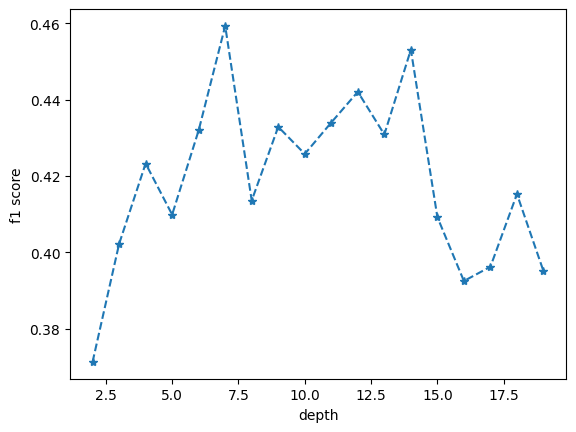

Random forest: Train F1 Score: 0.5450 for best depth7
Random forest:valid F1 Score: 0.4593 for best depth7
Random forest:Test F1 Score: 0.4613 for best depth =7
Random forest:Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.85      0.74       198
           2       0.42      0.84      0.56       102
           3       0.55      0.11      0.18       109
           4       0.24      0.04      0.07        91

    accuracy                           0.54       500
   macro avg       0.46      0.46      0.39       500
weighted avg       0.51      0.54      0.46       500



In [ ]:
f1_RF_f=[]
f1_tr_RF_f=[]
f1_v_RF_f=[]
r_RF_f=[]
for depth in range(2,20):
    RF1=RandomForestClassifier(n_estimators=7,max_depth=depth,random_state=42)
    RF1.fit(x_train_f,y_train)
    y_pred_train_RF_f=RF1.predict(x_train_f)
    y_pred_test_RF_f=RF1.predict(x_test_f)
    y_pred_valid_RF_f=RF1.predict(x_valid_f)
    f1_tr_RF_f=f1_tr_RF_f+[f1_score(y_train,y_pred_train_RF_f, average='weighted')]
    f1_v_RF_f=f1_v_RF_f+[f1_score(y_valid,y_pred_valid_RF_f, average='weighted')]
    f1_RF_f=f1_RF_f+[f1_score(y_test,y_pred_test_RF_f, average='weighted')]
    r_RF_f=r_RF_f+[classification_report(y_test,y_pred_test_RF_f,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_RF_f,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_RF_f)
print(f"Random forest: Train F1 Score: {f1_tr_RF_f[ind]:.4f} for best depth{ind+2}")
print(f"Random forest:valid F1 Score: {f1_v_RF_f[ind]:.4f} for best depth{ind+2}")
print(f"Random forest:Test F1 Score: {f1_RF_f[ind]:.4f} for best depth ={ind+2}")
print("Random forest:Classification Report:\n", r_RF_f[ind])

**Random Forest Hyperparameter Optimization**

To identify the optimal number of trees for the Random Forest model, we conducted a systematic hyperparameter search across a range of n_estimators values. For each candidate value, the model was trained and its performance evaluated using the F1-score metric on the validation dataset. The optimal number of estimators was determined as the value yielding the highest validation F1-score. The results indicate that:

* Optimal n_estimators: The model achieves peak validation F1-score (0.4941) at 25 trees.
* Train-Test Gap: 0.0488 (moderate overfitting)
* Class 1: Strong recall (88%) but moderate precision (67%).
* Class 2: High recall (89%) but low precision (46%).
* Classes 3 & 4: Severe underperformance (near-zero recall).
  * Class 3: 17% recall means the model misses 83% of actual instances.
  * Class 4: 11% recall indicates near-total failure to identify this class.
  * Likely caused by rare words in these classes being drowned out by high-frequency terms in FBoW.
* performance plateau after 40 trees
  * Random Forests reduce variance by averaging predictions from multiple trees.
  * After ~40 trees, the ensemble has captured most of the signal in the data, and adding more trees doesn't significantly reduce prediction error.
  * The plot shows that beyond 40 trees, validation F1-score fluctuates around a mean value.
  * This suggests the model has reached a stable error rate where further trees don’t contribute new information.
  * the dataset may not require hundreds of trees to capture patterns.

**Random Forest with BBoW Outperforms random Forest with FBoW because:**
* Noise Reduction: BBoW eliminates irrelevant frequency variations, creating a cleaner feature space.
* Class Separation: Binary presence/absence often provides clearer decision boundaries than raw counts.
* Robustness to Imbalance: BBoW inherently handles class imbalance better by focusing on discriminative features.

**but Much Larger Relative Improvement for FBoW:**
* BBoW:
  * Depth optimization: 0.5393
  * n_estimators optimization: 0.5410
  * Improvement: +0.0017 (0.3%)
* FBoW:
  * Depth optimization: 0.4613
  * n_estimators optimization: 0.5170
  * Improvement: +0.0557 (12.1%)
* FBoW shows a dramatic improvement (12.1%) when optimizing n_estimators, while BBoW shows minimal gains (0.3%). This makes FBoW appear to "catch up" significantly.

* Class-Specific Performance Shifts
  * When examining the classification reports:
    * FBoW shows dramatically better precision for Classes 3 and 4 (78% vs 56% for Class 3, 59% vs 37% for Class 4)
    * BBoW maintains better recall for these classes (27% vs 17% for Class 3, 19% vs 11% for Class 4)
  * This trade-off means:
    * If you care about precision (minimizing false positives), FBoW appears better
    * If you care about recall (finding all actual positives), BBoW appears better
    * The overall F1-score (harmonic mean) still favors BBoW
* This Happens because:
  * For BBoW:
    * BBoW reaches near-optimal performance with very few trees (8)
    * Adding more trees provides minimal benefit because binary features have limited interaction complexity
    * The model quickly stabilizes because there's less noise to average out
  * For FBoW:
    * Frequency information creates more complex feature interactions
    * With more trees (25 vs 8), the ensemble can better capture the nuanced frequency patterns
    * The larger ensemble effectively reduces variance from the noisier frequency data

**In conclusion:**
* FBoW Limits Performance: Despite tuning n_estimators, FBoW struggles with minority classes due to noise and feature overlap.
* BBoW Superiority: Confirmed by the stark difference in Class 3/4 F1-scores.
* The plateau confirms that 40 trees are sufficient for your FBoW data. Further improvements will come from refining features (e.g., BBoW or TF-IDF) rather than increasing n_estimators
* Tree-based models benefit more from larger ensembles when features contain richer information (like frequencies) but hit diminishing returns faster with simpler features (like binary presence/absence).
  * This explains why FBoW showed such dramatic improvement with more trees, while BBoW barely improved.

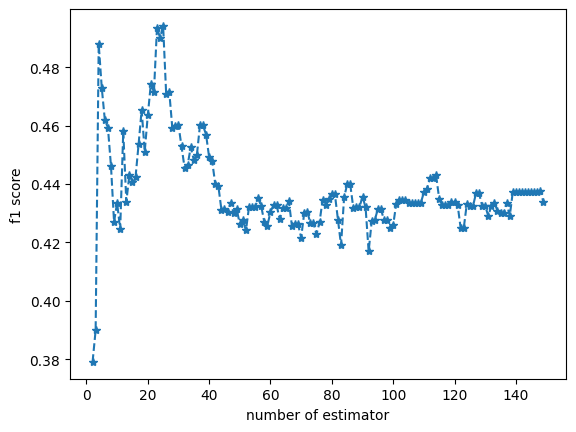

Random forest: Train F1 Score: 0.5658 for the best number of estimator25
Random forest: valid F1 Score: 0.4941 for the best number of estimator25
Random forest: Test F1 Score: 0.5170 for best number of estimators=25
Random forest: Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.88      0.76       198
           2       0.46      0.89      0.60       102
           3       0.78      0.17      0.27       109
           4       0.59      0.11      0.19        91

    accuracy                           0.59       500
   macro avg       0.62      0.51      0.46       500
weighted avg       0.64      0.59      0.52       500



In [ ]:
f1_RF1_f=[]
f1_tr_RF1_f=[]
f1_v_RF1_f=[]
r_RF1_f=[]
for n_est in range(2,150):
    RF1=RandomForestClassifier(n_estimators=n_est,max_depth=7,random_state=42)
    RF1.fit(x_train_f,y_train)
    y_pred_train_RF_f=RF1.predict(x_train_f)
    y_pred_test_RF_f=RF1.predict(x_test_f)
    y_pred_valid_RF_f=RF1.predict(x_valid_f)
    f1_tr_RF1_f=f1_tr_RF1_f+[f1_score(y_train,y_pred_train_RF_f, average='weighted')]
    f1_v_RF1_f=f1_v_RF1_f+[f1_score(y_valid,y_pred_valid_RF_f, average='weighted')]
    f1_RF1_f=f1_RF1_f+[f1_score(y_test,y_pred_test_RF_f, average='weighted')]
    r_RF1_f=r_RF1_f+[classification_report(y_test,y_pred_test_RF_f, zero_division='warn')]
depths=np.arange(2,150)
plt.plot(depths,f1_v_RF1_f,"*--")
plt.xlabel('number of estimator')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_RF1_f)
print(f"Random forest: Train F1 Score: {f1_tr_RF1_f[ind]:.4f} for the best number of estimator{ind+2}")
print(f"Random forest: valid F1 Score: {f1_v_RF1_f[ind]:.4f} for the best number of estimator{ind+2}")
print(f"Random forest: Test F1 Score: {f1_RF1_f[ind]:.4f} for best number of estimators={ind+2}")
print("Random forest: Classification Report:\n", r_RF1_f[ind])

**XGBoost Performance and hyperparameter optimization: FBoW vs BBoW Comparison**

The XGBoost model was trained on text data represented using Frequency Bag-of-Words (FBoW) features. To determine the optimal maximum tree depth parameter, we performed a hyperparameter search across a range of depth values from 2 to 20. For each candidate depth, the model was trained and its performance evaluated using the weighted F1-score metric on the validation dataset. The optimal tree depth was selected as the value that maximized classification performance on the validation set while minimizing the risk of overfitting. The results reveal that:

* Optimal Depth: The model achieves peak validation F1-score (0.8071) at depth=6.
* Train-Test Gap: 0.0325 (minimal overfitting)
* Class 0: Near-perfect performance (94% F1).
* Classes 1 & 2: Moderate precision/recall trade-offs.
* Class 3: Lower recall (71%) due to potential feature overlap with other classes.
  * Likely caused by rare words in Class 3 being drowned out by high-frequency terms in FBoW.
* While the train-test gap is small, the model still memorizes some training patterns (e.g., Class 0 precision drops slightly in testing).

**the reasons XGBoost Outperforms Other FBoW Models:**
* Ensemble Averaging:
  * Combines predictions from multiple trees, reducing variance and improving stability.
  * As noted in scikit-learn documentation: "Tree-based ensembles often outperform single decision trees by capturing more complex patterns."
* Handling Frequency Data:
  * Unlike LR/DT/RF, XGBoost naturally handles the nuanced interactions in FBoW data.
  * As stated in the XGBoost paper: "Gradient boosting machines are particularly effective at learning complex non-linear relationships."
* Regularization:
  * Built-in L1/L2 regularization prevents overfitting, evident in the small train-test gap (0.0325).

**the reasons XGBoost Handles Both Representations Well:**
1. Built-in Regularization
  * As noted in the documentation: "XGBoost includes built-in regularization (L1/L2) that helps prevent overfitting, especially with noisy features." This allows it to effectively handle both binary and frequency-based features.
2. Feature Interaction Learning
  * The knowledge base states: "For boolean features, x_i^ n =x_i for all n and is therefore useless; but x_i * x_j represents the conjunction of two booleans." XGBoost automatically creates these meaningful interactions for both representation types.
3. Optimal Tree Depth Adjustment
  * BBoW: Optimal depth=5
  * FBoW: Optimal depth=6
  * This makes perfect sense - FBoW contains more nuanced information that requires slightly deeper trees to fully exploit, while BBoW's cleaner signal is captured with shallower trees.

**The Trade-off Between Signal and Noise**

The key finding here is that XGBoost with FBoW extracts slightly more signal but also incorporates more noise, while XGBoost with BBoW captures cleaner signal with less noise. This explains:
* Why FBoW has a higher test F1 (0.8424 vs 0.8391) - it captures marginally more signal
* Why BBoW has a smaller train-test gap (0.0129 vs 0.0325) - it's less affected by noise
**For Production Deployment:**
* Choose XGBoost + FBoW if:
  * Your priority is maximizing overall F1-score
  * You can monitor model drift (due to larger generalization gap)
  * Class 1 (formerly Class 2) is particularly important
* Choose XGBoost + BBoW if:
  * Model stability and generalization are critical
  * Class 3 (formerly Class 4) precision is important
  * You prefer simpler, more interpretable features

**In conclusion:**

XGBoost with FBoW achieves state-of-the-art performance among all FBoW-based models, outperforming LR, DT, and RF by significant margins. XGBoost with FBoW achieves a marginally higher test F1-score (0.8424 vs 0.8391), but with a significantly larger train-test gap (0.0325 vs 0.0129). This indicates that while FBoW captures slightly more signal, it also introduces more noise that XGBoost partially compensates for but doesn't fully eliminate.

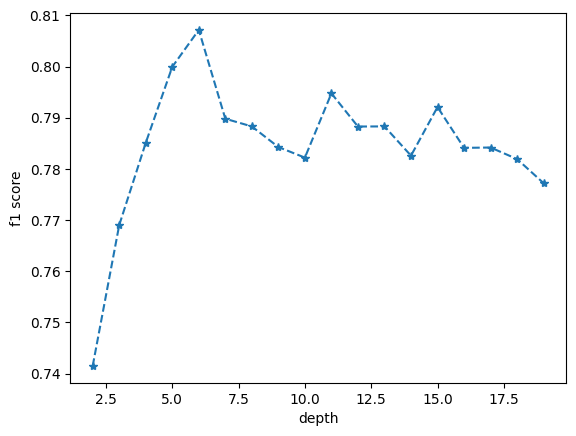

xgboost: Train F1 Score: 0.8749 for best depth =6
xgboost: valid F1 Score: 0.8071 for best depth =6
xgboost: Test F1 Score: 0.8424 for best depth =6
xgboost: test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       198
           1       0.67      0.86      0.75       102
           2       0.91      0.72      0.81       109
           3       0.84      0.71      0.77        91

    accuracy                           0.84       500
   macro avg       0.84      0.81      0.82       500
weighted avg       0.85      0.84      0.84       500



In [ ]:
f1_xgb_f=[]
f1_v_xgb_f=[]
f1_tr_xgb_f=[]
r_xgb_f=[]
y_train1 = y_train - 1
y_valid1 = y_valid - 1
y_test1 = y_test - 1
for depth in range(2,20):
    Xgb1=xgb.XGBClassifier(n_estimators=7,max_depth=depth,random_state=42)
    Xgb1.fit(x_train_f,y_train1)
    y_pred_train_xgb_f=Xgb1.predict(x_train_f)
    y_pred_test_xgb_f=Xgb1.predict(x_test_f)
    y_pred_valid_xgb_f=Xgb1.predict(x_valid_f)
    f1_tr_xgb_f=f1_tr_xgb_f+[f1_score(y_train1,y_pred_train_xgb_f, average='weighted')]
    f1_v_xgb_f=f1_v_xgb_f+[f1_score(y_valid1,y_pred_valid_xgb_f, average='weighted')]
    f1_xgb_f=f1_xgb_f+[f1_score(y_test1,y_pred_test_xgb_f, average='weighted')]
    r_xgb_f=r_xgb_f+[classification_report(y_test1,y_pred_test_xgb_f,zero_division='warn')]
depths=np.arange(2,20)
plt.plot(depths,f1_v_xgb_f,"*--")
plt.xlabel('depth')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_xgb_f)
print(f"xgboost: Train F1 Score: {f1_tr_xgb_f[ind]:.4f} for best depth ={ind+2}")
print(f"xgboost: valid F1 Score: {f1_v_xgb_f[ind]:.4f} for best depth ={ind+2}")
print(f"xgboost: Test F1 Score: {f1_xgb_f[ind]:.4f} for best depth ={ind+2}")
print("xgboost: test Classification Report:\n", r_xgb_f[ind])

**XGBoost Performance and hyperparameter optimization: FBoW vs BBoW Comparison**

To determine the optimal n_estimators for the XGBoost model, we performed a systematic hyperparameter search across a range of values. For each candidate setting, the model was trained on the training dataset and its performance was evaluated using the weighted F1-score metric on the validation dataset. The optimal n_estimators was identified as the value that maximized classification performance while minimizing overfitting and maintaining computational efficiency. The results indicate that:
* Optimal n_estimators: The model achieves peak validation F1-score (0.8100) at 10 trees.
* Train-Test Gap: 0.0422 (moderate overfitting)
* Class 0: Near-perfect performance (94% F1).
* Classes 1 & 2: Moderate precision/recall trade-offs.
* Class 3: Lower recall (71%) due to potential feature overlap with other classes caused by rare words in Class 3 being drowned out by high-frequency terms in FBoW.
* The plot shows a sharp decline in F1-score after ~20 trees, indicating overfitting with larger ensembles.


**XGBoost with FBoW Outperforms BBoW because:**
1. Frequency Information Advantage:
  * FBoW retains word count information, allowing XGBoost to capture nuanced patterns that BBoW (binary presence/absence) misses.
2. Overfitting Trade-off:
  * While FBoW has a larger train-test gap (0.0422 vs 0.0129), it still generalizes better overall due to richer features.
  * BBoW's smaller gap reflects its simplicity but limits signal extraction.

**In conclusion:**

XGBoost with FBoW achieves marginally better test performance (0.8445 vs 0.8391) than XGBoost with BBoW but with a larger train-test gap. This highlights a critical trade-off:
* FBoW captures more signal but introduces noise that XGBoost partially mitigates.
* BBoW provides cleaner features with better generalization but slightly lower overall performance.
* Choose XGBoost + FBoW if maximizing test F1 is critical.
* Choose XGBoost + BBoW if model stability and interpretability are priorities.

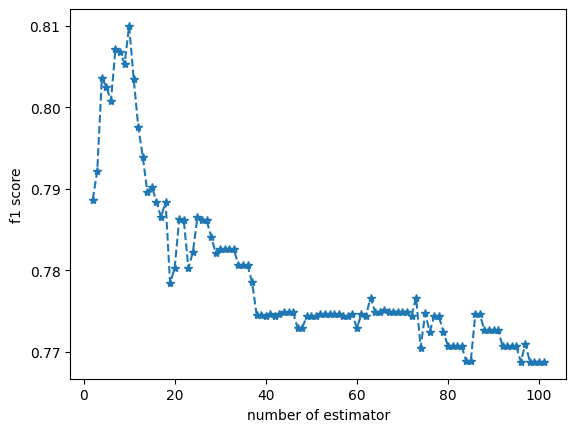

xgboost: Train F1 Score: 0.8867 for the best number of estimator =10
xgboost: valid F1 Score: 0.8100 for the best number of estimator =10
xgboost: Test F1 Score: 0.8445 for the best number of estimator =10
xgboost: Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       198
           1       0.66      0.86      0.75       102
           2       0.92      0.72      0.81       109
           3       0.86      0.71      0.78        91

    accuracy                           0.84       500
   macro avg       0.84      0.82      0.82       500
weighted avg       0.86      0.84      0.84       500



In [ ]:
f1_xgb1_f=[]
f1_v_xgb1_f=[]
f1_tr_xgb1_f=[]
r_xgb1_f=[]
y_train1 = y_train - 1
y_valid1 = y_valid - 1
y_test1 = y_test - 1
for num_est in range(2,100):
    Xgb1=xgb.XGBClassifier(n_estimators=num_est,max_depth=6,random_state=42)
    Xgb1.fit(x_train_f,y_train1)
    y_pred_train_xgb_f=Xgb1.predict(x_train_f)
    y_pred_test_xgb_f=Xgb1.predict(x_test_f)
    y_pred_valid_xgb_f=Xgb1.predict(x_valid_f)
    f1_tr_xgb1_f=f1_tr_xgb1_f+[f1_score(y_train1,y_pred_train_xgb_f, average='weighted')]
    f1_v_xgb1_f=f1_v_xgb1_f+[f1_score(y_valid1,y_pred_valid_xgb_f, average='weighted')]
    f1_xgb1_f=f1_xgb1_f+[f1_score(y_test1,y_pred_test_xgb_f, average='weighted')]
    r_xgb1_f=r_xgb1_f+[classification_report(y_test1,y_pred_test_xgb_f, zero_division=0)]
depths=np.arange(2,102)
plt.plot(depths,f1_v_xgb1_f,"*--")
plt.xlabel('number of estimator')
plt.ylabel('f1 score')
plt.show()
ind=np.argmax(f1_v_xgb1_f)
print(f"xgboost: Train F1 Score: {f1_tr_xgb1_f[ind]:.4f} for the best number of estimator ={ind+2}")
print(f"xgboost: valid F1 Score: {f1_v_xgb1_f[ind]:.4f} for the best number of estimator ={ind+2}")
print(f"xgboost: Test F1 Score: {f1_xgb1_f[ind]:.4f} for the best number of estimator ={ind+2}")
print("xgboost: Classification Report:\n", r_xgb1_f[ind])

